In [1]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np

# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"
import torch
import torchopt
from einops import rearrange, reduce
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms
from omegaconf import OmegaConf

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.evaluate_metric import Evaluate_MT1, Evaluate_MT2
from ese5934_project.models.GridField import Grid
from ese5934_project.models.operators import (
    C_adj,
    F_adj,
    ForwardModel,
    MaskedForwardModel,
)
from ese5934_project.models.SIREN import Siren, get_coordinates
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

# Create a mask function

In [2]:
def data_transform_2(
    kspace,
    mask,
    target,
    data_attributes,
    filename,
    slice_num,
):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


def data_transform_4(
    kspace,
    mask,
    target,
    data_attributes,
    filename,
    slice_num,
):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


def data_transform_8(
    kspace,
    mask,
    target,
    data_attributes,
    filename,
    slice_num,
):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


def data_transform_gt(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[1])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


dataset_gt = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_gt,
    challenge="multicoil",
)
dataset_2 = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_2,
    challenge="multicoil",
)
dataset_4 = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_4,
    challenge="multicoil",
)
dataset_8 = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_8,
    challenge="multicoil",
)

# get ground truth

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


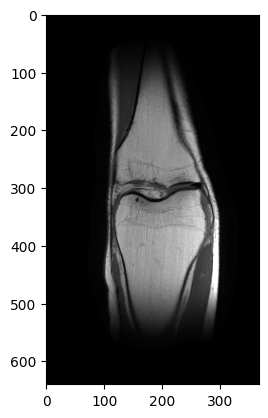

In [3]:
kspace, (mean, std), masked_kspace, mask, csm = dataset_gt[15]
f_adj = F_adj()
c_adj = C_adj()
image_gt = c_adj(f_adj(kspace), csm)
ground_truth_image = image_gt.squeeze()
from matplotlib import pyplot as plt

plt.imshow(torch.view_as_complex(image_gt).abs()[0], cmap="gray", vmax=25)

# Best Case Images with Acceleration Rate of 4

## Grid Field (Voxel Representation)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


ic| params.keys(): dict_keys(['grid'])


iteration 1, dc_loss: 2.9770655632019043, tv_loss: 0.0
iteration 2, dc_loss: 2.9171924591064453, tv_loss: 0.0002476871886756271
iteration 3, dc_loss: 2.8584272861480713, tv_loss: 0.00048622602480463684
iteration 4, dc_loss: 2.8007476329803467, tv_loss: 0.000722508761100471
iteration 5, dc_loss: 2.74413800239563, tv_loss: 0.0009582258644513786
iteration 6, dc_loss: 2.6885812282562256, tv_loss: 0.001193525968119502
iteration 7, dc_loss: 2.634061813354492, tv_loss: 0.001427414477802813
iteration 8, dc_loss: 2.580565929412842, tv_loss: 0.0016614214982837439
iteration 9, dc_loss: 2.5280795097351074, tv_loss: 0.0018910674843937159
iteration 10, dc_loss: 2.476588487625122, tv_loss: 0.0021193281281739473
iteration 11, dc_loss: 2.4260783195495605, tv_loss: 0.0023439370561391115
iteration 12, dc_loss: 2.376535177230835, tv_loss: 0.0025646330323070288
iteration 13, dc_loss: 2.327944278717041, tv_loss: 0.0027830027975142
iteration 14, dc_loss: 2.28029203414917, tv_loss: 0.002997355768457055
iterat

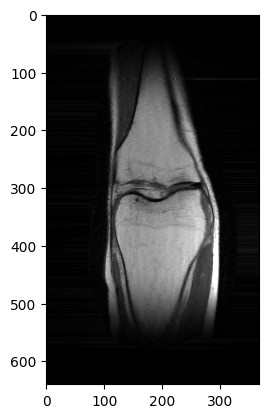

In [8]:
scheduler = lambda t: 0.8 ** (t // 400) * 1e-1
optimizer = torchopt.adam(lr=0.1)
kspace, (mean, std), masked_kspace, mask, csm = dataset_4[15]
field = Grid((640, 368), mean, std)
params, image_list_ADAM = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=4000,
    device=torch.device("cuda"),
)
plt.imshow(complex_abs(image_list_ADAM[-1]), cmap="gray", vmax=25)

## SIREN

In [24]:
device = torch.device("cuda")
size = (640, 368)
from ese5934_project.models.SIREN import Siren, get_coordinates

coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset_4[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=256,
    hidden_layers=8,
    outermost_linear=True,
    first_omega_0=25,
    hidden_omega_0=25,
)
lr_scheduler = lambda t: 0.8 ** (t // 400) * 1e-4
optimizer = torchopt.adamw(lr=lr_scheduler)
# 1e-4 1.092077389
# 1e-3 0.08540542
params, image_list_SIREN = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.01,
    optimizer=optimizer,
    iterations=4000,
    device=device,
)
plt.imshow(complex_abs(image_list_SIREN[-1]), cmap="gray", vmax=25)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.linear.weight', 'net.5.linear.bias', 'net.6.linear.weight', 'net.6.linear.bias', 'net.7.linear.weight', 'net.7.linear.bias', 'net.8.linear.weight', 'net.8.linear.bias', 'net.9.weight', 'net.9.bias'])


Done.
iteration 1, dc_loss: 3.011019706726074, tv_loss: 0.0017327064415439963
iteration 2, dc_loss: 2.9130382537841797, tv_loss: 0.002176767447963357
iteration 3, dc_loss: 2.850787401199341, tv_loss: 0.004349838476628065
iteration 4, dc_loss: 2.779738664627075, tv_loss: 0.006884200498461723
iteration 5, dc_loss: 2.739759922027588, tv_loss: 0.008020037785172462
iteration 6, dc_loss: 2.715916395187378, tv_loss: 0.00864491518586874
iteration 7, dc_loss: 2.6938934326171875, tv_loss: 0.009087405167520046
iteration 8, dc_loss: 2.675283432006836, tv_loss: 0.009270278736948967
iteration 9, dc_loss: 2.6572728157043457, tv_loss: 0.009474550373852253
iteration 10, dc_loss: 2.639674425125122, tv_loss: 0.009803587570786476
iteration 11, dc_loss: 2.6227874755859375, tv_loss: 0.00976830068975687
iteration 12, dc_loss: 2.6067543029785156, tv_loss: 0.009428935125470161
iteration 13, dc_loss: 2.591423749923706, tv_loss: 0.009527657181024551
iteration 14, dc_loss: 2.5770721435546875, tv_loss: 0.009319865

KeyboardInterrupt: 

## DictField

In [17]:
# from torch.utils.data import DataLoader
# from datalo

from ese5934_project.models.FactorFields import DictField, get_coordinates

base_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/defaults.yaml")
second_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/image.yaml")
cfg = OmegaConf.merge(
    base_conf,
    second_conf,
)

device = torch.device("cuda:0")
size = (640, 368)
model = DictField(cfg, size, device)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset_4[15]

scheduler = lambda t: 0.8 ** (t // 400) * 5e-3
optimizer = torchopt.adam(lr=scheduler)

params, image_list = reconstruct(
    model,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=4000,
    device=device,
)
plt.imshow(complex_abs(image_list[-1]), cmap="gray", vmax=25)

ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.freq_bands: tensor([40.0000, 24.6154, 18.2857, 14.2222, 11.8519, 10.0000], device='cuda:0')
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:0')
ic| self.coeff_reso: [20, 12]
ic| coeffs.shape: torch.Size([1, 144, 20, 12])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


=====> total parameters:  257584
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.


ValueError: too many values to unpack (expected 2)

In [88]:
results = {
    "ADAM": image_list_ADAM[-1],
    "SIREN": image_list_SIREN[-1],
    "DF": image_list[-1],
    "gt": image_gt.squeeze(),
}
torch.save(results, "experiments/best_case_comparision/images_dict.pt")
psnr_dict = {
    key: Evaluate_MT1(image_gt, value)[0]
    for key, value in results.items()
    if key != "gt"
}
torch.save(psnr_dict, "experiments/best_case_comparision/psnr_dict.pt")
ssim_dict = {
    key: Evaluate_MT1(image_gt, value)[1]
    for key, value in results.items()
    if key != "gt"
}
torch.save(ssim_dict, "experiments/best_case_comparision/ssim_dict.pt")

PSNR Value mt1: 35.51589318336404
SSIM Value mt1: 0.7751314202416238
PSNR Value mt1: 28.169658116720203
SSIM Value mt1: 0.8022582995267628
PSNR Value mt1: 38.49677393524084
SSIM Value mt1: 0.9359180332422214
PSNR Value mt1: 35.51589318336404
SSIM Value mt1: 0.7751314202416238
PSNR Value mt1: 28.169658116720203
SSIM Value mt1: 0.8022582995267628
PSNR Value mt1: 38.49677393524084
SSIM Value mt1: 0.9359180332422214


# Different ARs

In [7]:
import pandas as pd

ADAM_list = []
SIREN_list = []
DF_list = []
datasets_list = [dataset_gt, dataset_2, dataset_4, dataset_8]
# results = pd.DataFrame(
#     columns=[
#         "acceration_rate",
#         "psnr",
#         "ssim",
#     ],
#     index=[
#         "ADAM",
#         "SIREN",
#         "DF",
#     ],
# )
# results.loc["ADAM", "psnr"] = 0

In [25]:
for dataset, ar in zip(datasets_list, [1, 2, 4, 8]):
    scheduler = lambda t: 0.8 ** (t // 400) * 1e-1
    optimizer = torchopt.adam(lr=0.1)
    kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
    field = Grid((640, 368), mean, std)
    params, image_list_ADAM = reconstruct(
        field,
        torch.rand(1, 2),
        masked_kspace,
        csm,
        mask,
        alpha=0.005,
        optimizer=optimizer,
        iterations=4000,
        device=torch.device("cuda"),
    )
    psnr, ssim = Evaluate_MT1(image_gt, image_list_ADAM[-1])
    ADAM_list.append((psnr, ssim))

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['grid'])


Done.
iteration 1, dc_loss: 3.1375977993011475, tv_loss: 0.0
iteration 2, dc_loss: 3.0784525871276855, tv_loss: 0.00027480581775307655
iteration 3, dc_loss: 3.0205013751983643, tv_loss: 0.0005211131647229195
iteration 4, dc_loss: 2.9636640548706055, tv_loss: 0.0007560004014521837
iteration 5, dc_loss: 2.9078848361968994, tv_loss: 0.0009825904853641987
iteration 6, dc_loss: 2.8531177043914795, tv_loss: 0.0012002057628706098
iteration 7, dc_loss: 2.799330472946167, tv_loss: 0.0014088405296206474
iteration 8, dc_loss: 2.746499538421631, tv_loss: 0.0016107687260955572
iteration 9, dc_loss: 2.694606304168701, tv_loss: 0.0018039247952401638
iteration 10, dc_loss: 2.6436359882354736, tv_loss: 0.0019906985107809305
iteration 11, dc_loss: 2.5935754776000977, tv_loss: 0.0021706600673496723
iteration 12, dc_loss: 2.544412136077881, tv_loss: 0.0023450437001883984
iteration 13, dc_loss: 2.4961342811584473, tv_loss: 0.002515699714422226
iteration 14, dc_loss: 2.4487311840057373, tv_loss: 0.002682484

ic| params.keys(): dict_keys(['grid'])


Done.
iteration 1, dc_loss: 2.9683542251586914, tv_loss: 0.0
iteration 2, dc_loss: 2.9084701538085938, tv_loss: 0.0002550158533267677
iteration 3, dc_loss: 2.8496828079223633, tv_loss: 0.0005004259292036295
iteration 4, dc_loss: 2.7919692993164062, tv_loss: 0.000743578711990267
iteration 5, dc_loss: 2.7353129386901855, tv_loss: 0.0009861089056357741
iteration 6, dc_loss: 2.679697036743164, tv_loss: 0.001228003529831767
iteration 7, dc_loss: 2.625107526779175, tv_loss: 0.0014684407506138086
iteration 8, dc_loss: 2.571531295776367, tv_loss: 0.0017087629530578852
iteration 9, dc_loss: 2.518953800201416, tv_loss: 0.0019449278479442
iteration 10, dc_loss: 2.4673619270324707, tv_loss: 0.0021796380169689655
iteration 11, dc_loss: 2.4167418479919434, tv_loss: 0.0024107550270855427
iteration 12, dc_loss: 2.367079734802246, tv_loss: 0.002638190519064665
iteration 13, dc_loss: 2.318361520767212, tv_loss: 0.0028632809408009052
iteration 14, dc_loss: 2.2705740928649902, tv_loss: 0.00308453710749745

ic| params.keys(): dict_keys(['grid'])


Done.
iteration 1, dc_loss: 2.9717695713043213, tv_loss: 0.0
iteration 2, dc_loss: 2.911811113357544, tv_loss: 0.0002560284920036793
iteration 3, dc_loss: 2.8529512882232666, tv_loss: 0.0005029813037253916
iteration 4, dc_loss: 2.7951695919036865, tv_loss: 0.0007473558653146029
iteration 5, dc_loss: 2.738449811935425, tv_loss: 0.0009907493367791176
iteration 6, dc_loss: 2.682776927947998, tv_loss: 0.0012332746991887689
iteration 7, dc_loss: 2.628136157989502, tv_loss: 0.0014739499893039465
iteration 8, dc_loss: 2.5745139122009277, tv_loss: 0.0017143618315458298
iteration 9, dc_loss: 2.52189564704895, tv_loss: 0.0019502121722325683
iteration 10, dc_loss: 2.470266580581665, tv_loss: 0.0021846273448318243
iteration 11, dc_loss: 2.4196126461029053, tv_loss: 0.0024153287522494793
iteration 12, dc_loss: 2.3699188232421875, tv_loss: 0.0026421924121677876
iteration 13, dc_loss: 2.3211708068847656, tv_loss: 0.002866727067157626
iteration 14, dc_loss: 2.273355007171631, tv_loss: 0.00308728916570

ic| params.keys(): dict_keys(['grid'])


Done.
iteration 1, dc_loss: 2.99094820022583, tv_loss: 0.0
iteration 2, dc_loss: 2.9311585426330566, tv_loss: 0.0002514319494366646
iteration 3, dc_loss: 2.8724727630615234, tv_loss: 0.00049302022671327
iteration 4, dc_loss: 2.8148691654205322, tv_loss: 0.0007322695455513895
iteration 5, dc_loss: 2.7583281993865967, tv_loss: 0.0009708758443593979
iteration 6, dc_loss: 2.7028329372406006, tv_loss: 0.0012089830124750733
iteration 7, dc_loss: 2.648366689682007, tv_loss: 0.0014456139178946614
iteration 8, dc_loss: 2.5949132442474365, tv_loss: 0.001682184636592865
iteration 9, dc_loss: 2.5424578189849854, tv_loss: 0.0019143634708598256
iteration 10, dc_loss: 2.49098539352417, tv_loss: 0.002145118312910199
iteration 11, dc_loss: 2.440481662750244, tv_loss: 0.002372186630964279
iteration 12, dc_loss: 2.390932321548462, tv_loss: 0.0025952947326004505
iteration 13, dc_loss: 2.342323064804077, tv_loss: 0.0028159930370748043
iteration 14, dc_loss: 2.294640302658081, tv_loss: 0.003032678971067071


In [26]:
for dataset, ar in zip(datasets_list, [1, 2, 4, 8]):
    device = torch.device("cuda")
    size = (640, 368)
    from ese5934_project.models.SIREN import Siren, get_coordinates

    coords = get_coordinates(size)
    kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
    field = Siren(
        size,
        mean.to(device),
        std.to(device),
        in_features=2,
        out_features=2,
        hidden_features=256,
        hidden_layers=4,
        outermost_linear=True,
        first_omega_0=25,
        hidden_omega_0=25,
    )
    lr_scheduler = lambda t: 0.8 ** (t // 400) * 1e-4
    optimizer = torchopt.adamw(lr=lr_scheduler)
    # 1e-4 1.092077389
    # 1e-3 0.08540542
    params, image_list_SIREN = reconstruct(
        field,
        coords,
        masked_kspace,
        csm,
        mask,
        alpha=0.01,
        optimizer=optimizer,
        iterations=4000,
        device=device,
    )
    psnr, ssim = Evaluate_MT1(image_gt, image_list_ADAM[-1])
    SIREN_list.append((psnr, ssim))

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.
iteration 1, dc_loss: 3.18599009513855, tv_loss: 0.0005901351105421782
iteration 2, dc_loss: 3.0555496215820312, tv_loss: 0.003078893991187215
iteration 3, dc_loss: 2.9740359783172607, tv_loss: 0.005541853606700897
iteration 4, dc_loss: 2.9173800945281982, tv_loss: 0.007393249310553074
iteration 5, dc_loss: 2.8812050819396973, tv_loss: 0.00861265230923891
iteration 6, dc_loss: 2.8570971488952637, tv_loss: 0.009377313777804375
iteration 7, dc_loss: 2.8397624492645264, tv_loss: 0.00983405765146017
iteration 8, dc_loss: 2.8248579502105713, tv_loss: 0.010136129334568977
iteration 9, dc_loss: 2.8094234466552734, tv_loss: 0.010419312864542007
iteration 10, dc_loss: 2.793241500854492, tv_loss: 0.010728083550930023
iteration 11, dc_loss: 2.7774014472961426, tv_loss: 0.011017663404345512
iteration 12, dc_loss: 2.7619478702545166, tv_loss: 0.011285373941063881
iteration 13, dc_loss: 2.7462716102600098, tv_loss: 0.01155644841492176
iteration 14, dc_loss: 2.7313075065612793, tv_loss: 0.01181

ic| params.keys(): dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.
iteration 1, dc_loss: 2.953230619430542, tv_loss: 0.0003438346029724926
iteration 2, dc_loss: 2.824640989303589, tv_loss: 0.003585376078262925
iteration 3, dc_loss: 2.749671697616577, tv_loss: 0.006073945667594671
iteration 4, dc_loss: 2.7008719444274902, tv_loss: 0.00792218092828989
iteration 5, dc_loss: 2.671436071395874, tv_loss: 0.009071550332009792
iteration 6, dc_loss: 2.6513469219207764, tv_loss: 0.009749146178364754
iteration 7, dc_loss: 2.63533616065979, tv_loss: 0.010172576643526554
iteration 8, dc_loss: 2.6196398735046387, tv_loss: 0.010546237230300903
iteration 9, dc_loss: 2.6034185886383057, tv_loss: 0.010917861945927143
iteration 10, dc_loss: 2.5874154567718506, tv_loss: 0.011237578466534615
iteration 11, dc_loss: 2.571352243423462, tv_loss: 0.011504360474646091
iteration 12, dc_loss: 2.5555624961853027, tv_loss: 0.011751309037208557
iteration 13, dc_loss: 2.540461301803589, tv_loss: 0.012014058418571949
iteration 14, dc_loss: 2.5259487628936768, tv_loss: 0.01230798

ic| params = dict(fi: dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.
iteration 1, dc_loss: 3.005403518676758, tv_loss: 0.0005004759877920151
iteration 2, dc_loss: 2.8783397674560547, tv_loss: 0.0033010724000632763
iteration 3, dc_loss: 2.8058218955993652, tv_loss: 0.005649450235068798
iteration 4, dc_loss: 2.7543725967407227, tv_loss: 0.007261334452778101
iteration 5, dc_loss: 2.715136766433716, tv_loss: 0.008402793668210506
iteration 6, dc_loss: 2.6857385635375977, tv_loss: 0.009193306788802147
iteration 7, dc_loss: 2.664520263671875, tv_loss: 0.009729486890137196
iteration 8, dc_loss: 2.647268533706665, tv_loss: 0.010113631375133991
iteration 9, dc_loss: 2.6308071613311768, tv_loss: 0.010357657447457314
iteration 10, dc_loss: 2.614577054977417, tv_loss: 0.010506504215300083
iteration 11, dc_loss: 2.5979108810424805, tv_loss: 0.010666261427104473
iteration 12, dc_loss: 2.582097291946411, tv_loss: 0.010824855417013168
iteration 13, dc_loss: 2.567143678665161, tv_loss: 0.010946669615805149
iteration 14, dc_loss: 2.552508592605591, tv_loss: 0.011023

ic| params = dict(fi: dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.linear.weight', 'net.4.linear.bias', 'net.5.weight', 'net.5.bias'])


Done.
iteration 1, dc_loss: 2.935042142868042, tv_loss: 0.0008581512374803424
iteration 2, dc_loss: 2.813906192779541, tv_loss: 0.004346647299826145
iteration 3, dc_loss: 2.748802423477173, tv_loss: 0.0064378357492387295
iteration 4, dc_loss: 2.7061820030212402, tv_loss: 0.007817002013325691
iteration 5, dc_loss: 2.6745200157165527, tv_loss: 0.008727215230464935
iteration 6, dc_loss: 2.6500349044799805, tv_loss: 0.009370515123009682
iteration 7, dc_loss: 2.6297852993011475, tv_loss: 0.009868411347270012
iteration 8, dc_loss: 2.611405849456787, tv_loss: 0.010255226865410805
iteration 9, dc_loss: 2.594622850418091, tv_loss: 0.010551880113780499
iteration 10, dc_loss: 2.5781402587890625, tv_loss: 0.010800882242619991
iteration 11, dc_loss: 2.5617458820343018, tv_loss: 0.010989588685333729
iteration 12, dc_loss: 2.5462396144866943, tv_loss: 0.011076439172029495
iteration 13, dc_loss: 2.531658172607422, tv_loss: 0.01109855342656374
iteration 14, dc_loss: 2.517054796218872, tv_loss: 0.011168

In [27]:
from ese5934_project.models.FactorFields import DictField, get_coordinates

base_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/defaults.yaml")
second_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/image.yaml")
cfg = OmegaConf.merge(
    base_conf,
    second_conf,
)
for dataset, ar in zip(datasets_list, [1, 2, 4, 8]):
    device = torch.device("cuda:1")
    size = (640, 368)
    model = DictField(cfg, size, device)

    coords = get_coordinates(size)
    kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
    scheduler = lambda t: 0.8 ** (t // 400) * 5e-3
    optimizer = torchopt.adam(lr=scheduler)

    params, image_list = reconstruct(
        model,
        coords,
        masked_kspace,
        csm,
        mask,
        alpha=0.005,
        optimizer=optimizer,
        iterations=4000,
        device=device,
    )
    psnr, ssim = Evaluate_MT1(image_gt, image_list_ADAM[-1])
    DF_list.append((psnr, ssim))

ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.freq_bands: tensor([40.0000, 24.6154, 18.2857, 14.2222, 11.8519, 10.0000], device='cuda:1')
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:1')
ic| self.coeff_reso: [20, 12]
ic| coeffs.shape: torch.Size([1, 144, 20, 12])
ic| [1, basis_dim] + [reso] * self.in_dim: [1,

 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


=====> total parameters:  257584
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.


ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.freq_bands: tensor([40.0000, 24.6154, 18.2857, 14.2222, 11.8519, 10.0000], device='cuda:1')
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:1')
ic| self.coeff_reso: [20, 12]
ic| coeffs.shape: torch.Size([1, 144, 20, 12])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


PSNR Value mt1: 35.77876077524474
SSIM Value mt1: 0.7715722252164936
=====> total parameters:  257584
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.


ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.freq_bands: tensor([40.0000, 24.6154, 18.2857, 14.2222, 11.8519, 10.0000], device='cuda:1')
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:1')
ic| self.coeff_reso: [20, 12]
ic| coeffs.shape: torch.Size([1, 144, 20, 12])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


PSNR Value mt1: 35.77876077524474
SSIM Value mt1: 0.7715722252164936
=====> total parameters:  257584
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.


ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([16, 26, 35, 45, 54, 64])
ic| self.freq_bands: tensor([40.0000, 24.6154, 18.2857, 14.2222, 11.8519, 10.0000], device='cuda:1')
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:1')
ic| self.coeff_reso: [20, 12]
ic| coeffs.shape: torch.Size([1, 144, 20, 12])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 16, 16]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 26, 26]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 35, 35]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 45, 45]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 54, 54]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 64, 64]


PSNR Value mt1: 35.77876077524474
SSIM Value mt1: 0.7715722252164936
=====> total parameters:  257584
tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


Done.
PSNR Value mt1: 35.77876077524474
SSIM Value mt1: 0.7715722252164936


In [28]:
torch.save(
    {"ADAM": ADAM_list, "SIREN": SIREN_list, "DF": DF_list}, "results_AR_1_2_4_8.pt"
)

In [32]:
print(DF_list)

[(35.239742876024216, 0.7594775679989919), (35.239742876024216, 0.7594775679989919), (35.239742876024216, 0.7594775679989919), (35.239742876024216, 0.7594775679989919), (35.77876077524474, 0.7715722252164936), (35.77876077524474, 0.7715722252164936), (35.77876077524474, 0.7715722252164936), (35.77876077524474, 0.7715722252164936)]


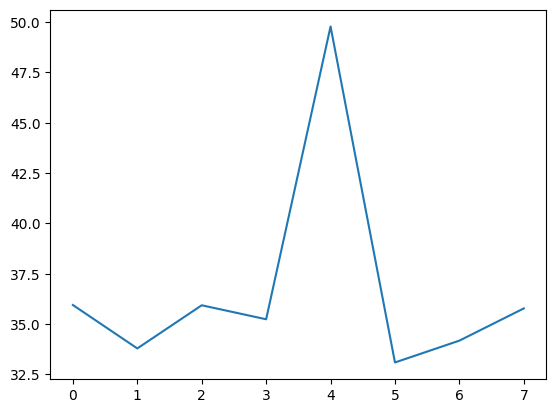

In [33]:
plt.plot([d[0] for d in ADAM_list])

In [ ]:
results.to_excel("experiments/AR_results.xlsx")

ModuleNotFoundError: No module named 'openpyxl'

In [89]:
for k, v in results.items():
    print(k)
    Evaluate_MT1(image_gt, v)

ADAM
PSNR Value mt1: 35.51589318336404
SSIM Value mt1: 0.7751314202416238
SIREN
PSNR Value mt1: 28.169658116720203
SSIM Value mt1: 0.8022582995267628
DF
PSNR Value mt1: 38.49677393524084
SSIM Value mt1: 0.9359180332422214
gt
PSNR Value mt1: inf
SSIM Value mt1: 1.0


/bmrc-homes/nmrgrp/nmr201/micromamba/envs/python311/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


In [71]:
Evaluate_MT2(image_gt, image_list[-1])

PSNR Value mt2: 37.331352482059785
SSIM Value mt2: 0.9279717622379655


(37.331352482059785, 0.9279717622379655)